In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline
np.random.seed(1)
from sklearn.preprocessing import MinMaxScaler

In [2]:
def load_dataset():
    train_dataset=h5py.File('./train_signs.h5','r')
    train_set_x_orig=np.array(train_dataset["train_set_x"][:])
    train_set_y_orig=np.array(train_dataset['train_set_y'][:])
    test_dataset=h5py.File('./test_signs.h5','r')
    test_set_x_orig=np.array(test_dataset['test_set_x'][:])
    test_set_y_orig=np.array(test_dataset['test_set_y'][:])
    classes=np.array(test_dataset['list_classes'][:])
    train_set_y_orig=train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
    test_set_y_orig=test_set_y_orig.reshape((1,test_set_y_orig.shape[0]))
    return train_set_x_orig,train_set_y_orig,test_set_x_orig,test_set_y_orig,classes
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    X.shape = 
    """
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [100]:
X_train,Y_train,X_test,Y_test,classes=load_dataset()

In [101]:
print(X_train.shape)
print(Y_train.shape)

(1080, 64, 64, 3)
(1, 1080)


5


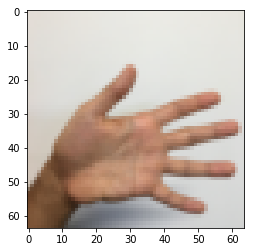

In [102]:
#lets display the first image in dataset
plt.figure()

plt.imshow(X_train[0])

print(np.squeeze(Y_train[:,0]))


In [103]:
def convert_to_one_hot(Y,num_cls):
    return np.eye(num_cls)[Y.reshape(-1)]
    

In [104]:
## scaling the datset

X_train=MinMaxScaler(X_train)
X_test=MinMaxScaler(X_test)
Y_train=convert_to_one_hot(Y_train,6)
Y_test=convert_to_one_hot(Y_test,6)
print('Shape of training labels {}'.format(Y_train.shape))
my_classes=np.unique(np.squeeze(Y_train))#alternate although I have classes variable from data
num_classes=len(classes)




Shape of training labels (1080, 6)


In [105]:
conv_layers={}


In [106]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    """
    n_H0=height of input image
    n_W0=width of input image
    n_C0=number of channels of the input image
    n_y=number of classes
    """
    
    X=tf.placeholder(tf.float32,shape=[None,n_H0,n_W0,n_C0])
    Y=tf.placeholder(tf.float32,shape=[None,n_y])
    
    """
    returns 
    X = placeholder for input of shape [None,n_H0,n_W0,n_C0]
    Y=placeholder for input labels of shape [None,n_y]
    """
    
    return X,Y

In [107]:
X,Y=create_placeholders(64,64,3,6)

In [108]:
def initialize_parameters():
    """
    initializes weights
    W1 : shape is [4,4,3,8] , 8 is the no. filters
    W2 : shape is [2,2,8,16] ,16 is the no. filters
    """
    tf.set_random_seed(1)
    
    W1=tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters={"W1":W1,
               "W2":W2}
    return parameters
    

In [109]:
def forward_propagation(X,parameters):
    """
    CONV2D -> RELU -> MAXPOOL ->CONV2D-> RELU ->MAXPOOL -> FLATTEN ->  FULLYCONNECTED
    """
    W1=parameters['W1']
    W2=parameters['W2']
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    A2=tf.nn.relu(Z2)
    P2=tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    # flattening the pool layer 
    P2_flatten=tf.contrib.layers.flatten(P2)
    P2_flatten=tf.nn.dropout(P2_flatten,0.5)
    Z3=tf.contrib.layers.fully_connected(P2_flatten,num_outputs=6,activation_fn=None)
    return Z3 
    

In [110]:
def compute_cost(logits,Y):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=Y))
    return cost

In [111]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,num_epochs=100,minibatch=100,minibatch_size=64,print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]
    costs=[]
    
    X,Y=create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    cost=compute_cost(Z3,Y)
    #backpropagation
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            """
            below variables will be initialized after each epoch"""
            minibatch_cost=0
            num_minibatches=int(m/minibatch_size)
            seed=seed+1
            minibatches=random_mini_batches(X_train,Y_train,minibatch_size,seed)
            for minibatch in minibatches:
                minibatch_X,minibatch_Y=minibatch
                _,temp_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
            minibatch_cost+=temp_cost/num_minibatches
            costs.append(minibatch_cost)
            if epoch%2==0:
                print("cost after {} is {}".format(epoch,minibatch_cost))
         
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('after each 2nd epoch ')
        plt.show()
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

cost after 0 is 0.11185959726572037
cost after 2 is 0.11236643046140671
cost after 4 is 0.11198312789201736
cost after 6 is 0.11205929517745972
cost after 8 is 0.11197996139526367
cost after 10 is 0.11225778609514236
cost after 12 is 0.11203398555517197
cost after 14 is 0.11215509474277496
cost after 16 is 0.11209572851657867
cost after 18 is 0.11191675812005997
cost after 20 is 0.11206506192684174
cost after 22 is 0.11129968613386154
cost after 24 is 0.09655576199293137
cost after 26 is 0.10065913200378418
cost after 28 is 0.10487502068281174
cost after 30 is 0.09493931382894516
cost after 32 is 0.09850086271762848
cost after 34 is 0.09969385713338852
cost after 36 is 0.08583474159240723
cost after 38 is 0.08906049281358719
cost after 40 is 0.09632635861635208
cost after 42 is 0.09666401892900467
cost after 44 is 0.09637705981731415
cost after 46 is 0.08279634267091751
cost after 48 is 0.07988917082548141
cost after 50 is 0.0921289250254631
cost after 52 is 0.08919995278120041
cost af

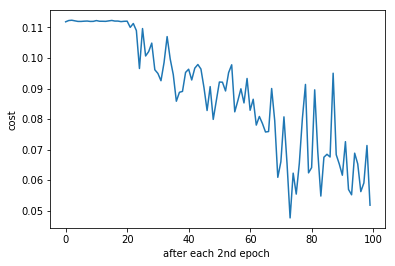

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.666667
Test Accuracy: 0.566667


NameError: name 'parameter' is not defined

In [112]:
model(X_train,Y_train,X_test,Y_test)